<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

# ***Analyzing the dataset and doing the cleansing***

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)
saved_columns= np.array(dataset_identity.columns)

In [6]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [7]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [5]:
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  a = dataset_identity.pop(column)

In [6]:
merged_data = pd.merge(left=dataset_transaction, right=dataset_identity, how='left', left_on='TransactionID', right_on='TransactionID')

dataset_transaction = None
dataset_identity = None
merged_data.shape

(590540, 430)

In [10]:
merged_data.tail(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Check NaN, Null, and OneHotEncoding**

In [7]:
dataset_transaction = copy.copy(merged_data)
merged_data = None
dataset_identity = None

float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']
cache = dict()
print(len(float_columns), len(int_columns), len(obj_columns))

399 2 27


In [12]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  max_X = np.max(X_temp)
  min_X = np.min(X_temp)
  mean_X = np.mean(X_temp)
  X_out.iloc[indices] = (X_temp - mean_X)/(max_X - min_X)
  X_out.iloc[np.where(np.isnan(X_out))[0]] = mean_X
  return min_X, max_X, mean_X, X_out.astype('float32')

In [20]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,32.0,match_status:2,T,F,T,T,mobile


In [13]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns
for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float32')

  # Code the NaN column for every features
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [22]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code,id_01_NaN_Code,id_02_NaN_Code,id_03_NaN_Code,id_04_NaN_Code,id_05_NaN_Code,id_06_NaN_Code,id_07_NaN_Code,id_08_NaN_Code,id_09_NaN_Code,id_10_NaN_Code,id_11_NaN_Code,id_13_NaN_Code,id_14_NaN_Code,id_17_NaN_Code,id_18_NaN_Code,id_19_NaN_Code,id_20_NaN_Code,id_21_NaN_Code,id_22_NaN_Code,id_24_NaN_Code,id_25_NaN_Code,id_26_NaN_Code,id_32_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,362.500000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,231.875,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,169.625000,-0.018738,140.000000,42.343750,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,118.500000,231.875,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,-0.141235,42.343750,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,231.875,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,-0.141235,42.343750,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,118.500000,231.875,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,118.500000,231.875,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,140.000000,42.343750,69.8125,41.625,146.0,0.561035,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,1,0


In [14]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('float32')

  # Code the NaN feature
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [15]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code,id_01_NaN_Code,id_02_NaN_Code,id_03_NaN_Code,id_04_NaN_Code,id_05_NaN_Code,id_06_NaN_Code,id_07_NaN_Code,id_08_NaN_Code,id_09_NaN_Code,id_10_NaN_Code,id_11_NaN_Code,id_13_NaN_Code,id_14_NaN_Code,id_17_NaN_Code,id_18_NaN_Code,id_19_NaN_Code,id_20_NaN_Code,id_21_NaN_Code,id_22_NaN_Code,id_24_NaN_Code,id_25_NaN_Code,id_26_NaN_Code,id_32_NaN_Code,TransactionDT_NaN_Code,card1_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,362.500000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,231.875,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,169.625000,-0.018738,140.000000,42.343750,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,118.500000,231.875,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,-0.141235,42.343750,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,231.875,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,-0.141235,42.343750,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,118.500000,231.875,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,69.8125,41.625,146.0,0.561035,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,118.500000,231.875,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,140.000000,42.343750,69.8125,41.625,146.0,0.561035,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,1,0,0,0


In [15]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass


Encoded columns: 207


In [17]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.463379,-0.002083,0.231445,362.500000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,231.875,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,169.625000,-0.018738,140.000000,42.343750,69.8125,41.625,146.0,0.561035,-0.126709,-0.184814,54.03125,17.90625,57.71875,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,118.500000,231.875,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,-0.141235,42.343750,69.8125,41.625,146.0,0.561035,-0.141479,146.625000,54.03125,17.90625,57.71875,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,231.875,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,-0.141235,42.343750,69.8125,41.625,146.0,0.561035,-0.141479,0.232910,54.03125,17.90625,57.71875,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,118.500000,231.875,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,69.8125,41.625,146.0,0.561035,-0.045654,146.625000,54.03125,17.90625,57.71875,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,118.500000,231.875,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,169.625000,28.343750,140.000000,42.343750,69.8125,41.625,146.0,0.561035,124.000000,146.625000,54.03125,17.90625,57.71875,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [16]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


**Apply Seaborn to preliminary analyze the dataset**

In [17]:
out = ['isFraud']
for column in dataset_transaction.columns:
  if column.find('R_emaildomain') != -1:
    out.append(column)
  if column.find('P_emaildomain') != -1:
    out.append(column)
print(out)

['isFraud', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'P_emaildomain_5', 'P_emaildomain_6', 'P_emaildomain_7', 'P_emaildomain_8', 'P_emaildomain_9', 'P_emaildomain_10', 'P_emaildomain_11', 'P_emaildomain_12', 'P_emaildomain_13', 'P_emaildomain_14', 'P_emaildomain_15', 'P_emaildomain_16', 'P_emaildomain_17', 'P_emaildomain_18', 'P_emaildomain_19', 'P_emaildomain_20', 'P_emaildomain_21', 'P_emaildomain_22', 'P_emaildomain_23', 'P_emaildomain_24', 'P_emaildomain_25', 'P_emaildomain_26', 'P_emaildomain_27', 'P_emaildomain_28', 'P_emaildomain_29', 'P_emaildomain_30', 'P_emaildomain_31', 'P_emaildomain_32', 'P_emaildomain_33', 'P_emaildomain_34', 'P_emaildomain_35', 'P_emaildomain_36', 'P_emaildomain_37', 'P_emaildomain_38', 'P_emaildomain_39', 'P_emaildomain_40', 'P_emaildomain_41', 'P_emaildomain_42', 'P_emaildomain_43', 'P_emaildomain_44', 'P_emaildomain_45', 'P_emaildomain_46', 'P_emaildomain_47', 'P_emaildomain_48', 'P_emaildomain_49'

In [18]:
#columns_to_analyze = ['isFraud', 'DeviceType_0', 'DeviceType_1', 'DeviceType_2', 'id_15_0', 'id_15_1', 'id_15_2', 'id_15_3']#, 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2', 'card1', 'card2', 'card3']
columns_to_analyze = out

analyzing_data = dataset_transaction[columns_to_analyze]

In [19]:
corr = analyzing_data.corr()
to_display = False

if to_display:
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
# Remove the weak correlation features
col = corr.columns
is_fraud = np.where(col=='isFraud')[0][0]
col = col.to_list()
col.pop(is_fraud)
to_remove = []
for each_col in col:
  if abs(corr['isFraud'][each_col]) < 0.01: # Weak correlation
    to_remove.append(each_col)
    a = dataset_transaction.pop(each_col)
print(len(to_remove))
analyzing_data = None


dataset_transaction.head(5)

99


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.463341,-0.002083,0.231505,362.555481,-0.024389,-0.418094,0.055150,0.002167,-0.009674,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001544,-0.016573,-0.001609,-0.002585,-0.001279,-0.010809,-0.005105,-0.125543,169.563232,-0.018734,140.002441,42.335964,69.805717,41.63895,146.058105,0.561057,-0.126692,-0.184815,54.037533,17.901295,57.724445,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.463341,-0.003320,-0.410654,0.082889,-0.024389,-0.710065,0.077878,0.002167,118.502182,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001544,-0.021334,-0.001609,-0.002899,-0.001279,-0.010809,-0.005105,-0.147418,169.563232,28.343348,-0.141274,42.335964,69.805717,41.63895,146.058105,0.561057,-0.141532,146.621460,54.037533,17.901295,57.724445,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.463337,-0.002381,-0.300973,0.254889,-0.024389,-0.242912,0.089241,0.002167,0.016381,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001544,-0.016573,-0.001609,-0.002899,-0.001279,-0.010809,-0.005105,-0.147418,169.563232,28.343348,-0.141274,42.335964,69.805717,41.63895,146.058105,0.561057,-0.141532,0.232889,54.037533,17.901295,57.724445,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.463335,-0.002662,0.473285,0.408889,-0.024389,-0.600576,0.421060,0.002167,118.502182,231.855423,-0.002581,-0.001805,-0.000217,-0.001816,-0.015964,-0.002251,-0.001263,-0.001544,-0.016573,-0.001609,-0.002899,-0.001279,-0.002584,-0.005105,0.027582,-0.089943,-0.034607,-0.046420,-0.051692,69.805717,41.63895,146.058105,0.561057,-0.045642,146.621460,54.037533,17.901295,57.724445,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.463334,-0.002662,-0.310516,0.302889,-0.024389,-0.710065,0.293787,0.002167,118.502182,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001244,-0.021334,-0.001302,-0.002899,-0.001279,-0.010809,-0.005105,-0.147418,169.563232,28.343348,140.002441,42.335964,69.805717,41.63895,146.058105,0.561057,123.982140,146.621460,54.037533,17.901295,57.724445,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


# ***Creat the train/val dataset***

In [21]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
a = dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,0,-0.463341,-0.002083,0.231505,362.555481,-0.024389,-0.418094,0.055150,0.002167,-0.009674,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001544,-0.016573,-0.001609,-0.002585,-0.001279,-0.010809,-0.005105,-0.125543,169.563232,-0.018734,140.002441,42.335964,69.805717,41.63895,146.058105,0.561057,-0.126692,-0.184815,54.037533,17.901295,57.724445,-0.170213,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,0,-0.463341,-0.003320,-0.410654,0.082889,-0.024389,-0.710065,0.077878,0.002167,118.502182,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001544,-0.021334,-0.001609,-0.002899,-0.001279,-0.010809,-0.005105,-0.147418,169.563232,28.343348,-0.141274,42.335964,69.805717,41.63895,146.058105,0.561057,-0.141532,146.621460,54.037533,17.901295,57.724445,-0.170213,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0,-0.463337,-0.002381,-0.300973,0.254889,-0.024389,-0.242912,0.089241,0.002167,0.016381,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001544,-0.016573,-0.001609,-0.002899,-0.001279,-0.010809,-0.005105,-0.147418,169.563232,28.343348,-0.141274,42.335964,69.805717,41.63895,146.058105,0.561057,-0.141532,0.232889,54.037533,17.901295,57.724445,0.157230,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,0,-0.463335,-0.002662,0.473285,0.408889,-0.024389,-0.600576,0.421060,0.002167,118.502182,231.855423,-0.002581,-0.001805,-0.000217,-0.001816,-0.015964,-0.002251,-0.001263,-0.001544,-0.016573,-0.001609,-0.002899,-0.001279,-0.002584,-0.005105,0.027582,-0.089943,-0.034607,-0.046420,-0.051692,69.805717,41.63895,146.058105,0.561057,-0.045642,146.621460,54.037533,17.901295,57.724445,-0.054828,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,0,-0.463334,-0.002662,-0.310516,0.302889,-0.024389,-0.710065,0.293787,0.002167,118.502182,231.855423,-0.002795,-0.002507,-0.000217,-0.001816,-0.015964,-0.003582,-0.001263,-0.001244,-0.021334,-0.001302,-0.002899,-0.001279,-0.010809,-0.005105,-0.147418,169.563232,28.343348,140.002441,42.335964,69.805717,41.63895,146.058105,0.561057,123.982140,146.621460,54.037533,17.901295,57.724445,163.744583,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [22]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01)
X_train = X
Y_train = Y

#test_size = 20000
#indices = np.random.randint(0, len(Y), size=(test_size,))
#X_test = np.array(X_train)[indices]
#Y_test = np.array(Y_train)[indices]

Percentage of Fraud: 3.5%


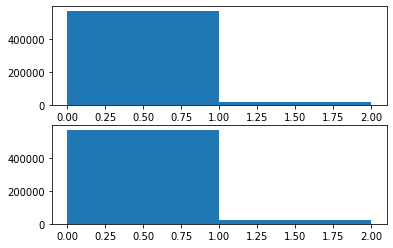

In [23]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

**Downsampling and upsampling**

In [24]:
downsampling_factor = 2
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 5
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

indices_0_new = tf.random.shuffle(indices_0_new)

X_new = np.array(X_train)[indices_0_new]
Y_new = np.array(Y_train)[indices_0_new]

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.05)

X_to_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]))
Y_to_train = np.squeeze(Y_train, axis=1)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))
Y_test = np.squeeze(Y_test, axis=1)


print(X_to_train.shape, X_test.shape)

(284939, 1)
(388471, 910) (20446, 910)


**Check the imbalane of the train/test dataset**

Percentage of Fraud: 30.3%


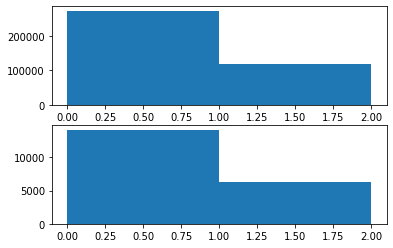

In [25]:
X_new = None
Y_new = None

plt.subplot(211)
plt.hist(Y_to_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# ***The model using NN***

In [26]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [27]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  
  out_model.add(Dense(dense1, activation='relu',
                      input_shape=(X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense1, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))

  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))

  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(int(dense2/2), activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(int(dense2/2), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))

  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[METRICS])
  
  return out_model

In [28]:
#my_model = create_model(dense1=256, dense2=256, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.1, lr=0.00008)
my_model = create_model(dense1=256, dense2=256, dropout_rate=0.4, l1_rate=5e-5, l2_rate=1e-5, init_std=0.1, lr=0.0001)
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               233216    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
BATCH_SIZE = 256
NB_EPOCH = 2000
PATIENCE = 25

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = my_model.fit(X_to_train, Y_to_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.01, shuffle=True,
             callbacks=[early_stop, best_model_hold])

Epoch 1/2000
1502/1503 [============================>.] - ETA: 0s - loss: 17360.0879 - tp: 45720.0000 - fp: 45761.0000 - tn: 222188.0000 - fn: 70843.0000 - accuracy: 0.6967 - precision: 0.4998 - recall: 0.3922 - auc: 0.6312
Epoch 00001: val_auc improved from -inf to 0.69068, saving model to ./best_model.h5
1503/1503 [==============================] - 24s 16ms/step - loss: 17356.7695 - tp: 45728.0000 - fp: 45765.0000 - tn: 222237.0000 - fn: 70856.0000 - accuracy: 0.6968 - precision: 0.4998 - recall: 0.3922 - auc: 0.6312 - val_loss: 146.6948 - val_tp: 421.0000 - val_fp: 270.0000 - val_tn: 2493.0000 - val_fn: 701.0000 - val_accuracy: 0.7501 - val_precision: 0.6093 - val_recall: 0.3752 - val_auc: 0.6907
Epoch 2/2000
1500/1503 [============================>.] - ETA: 0s - loss: 65.1793 - tp: 38338.0000 - fp: 23546.0000 - tn: 244048.0000 - fn: 78068.0000 - accuracy: 0.7354 - precision: 0.6195 - recall: 0.3293 - auc: 0.6651
Epoch 00002: val_auc improved from 0.69068 to 0.69411, saving model to

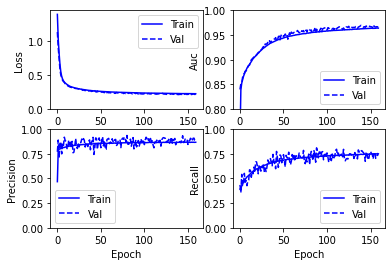

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)


**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [ ]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/best_model_20200805_METRICS.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.01)})
new_model = tf.keras.models.load_model('./best_model.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/best_model_20200802_METRICS.h5', 
#                                        custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.01)})
new_model.summary()

NameError: ignored

In [ ]:
# Empty some RAM space
indices_0_new = None
data_backup = None
dataset_transaction = None
X_to_train = None
Y_to_train = None
Y_train = None
X_train = None

In [ ]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  y_pred = (model.predict(X_test, batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
 
  precision = precision_cal(y_pred, y_ref)
  recall = recall_cal(y_pred, y_ref)

  return precision, recall, 2*precision*recall/(precision+recall)

In [ ]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

threshold_value = []
indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)

  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_to_train[indices], Y_to_train[indices], test_size=len(Y_to_train[indices]), threshold=threshold_value[-1])

  pre_train.append(temp_pre)
  re_train.append(temp_re)
  f1_train.append(temp_f1)


In [ ]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

plt.plot(threshold_value, f1_train, '--b')
plt.plot(threshold_value, pre_train, '--r')
plt.plot(threshold_value, re_train, '--g')

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.2270195335149765
tp :  4320.0
fp :  500.0
tn :  28057.0
fn :  1816.0
accuracy :  0.9332430362701416
precision :  0.8962655663490295
recall :  0.7040417194366455
auc :  0.9600683450698853

Legitimate Transactions Detected (True Negatives):  27436
Legitimate Transactions Incorrectly Detected (False Positives):  1121
Fraudulent Transactions Missed (False Negatives):  1225
Fraudulent Transactions Detected (True Positives):  4911
Total Fraudulent Transactions:  6136


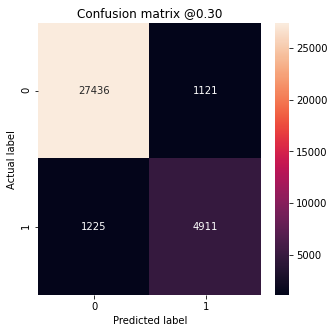

In [ ]:
#BATCH_SIZE = 256
baseline_results = new_model.evaluate(X_test, Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(new_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions = new_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

plot_cm(Y_test, predictions, p=0.3)

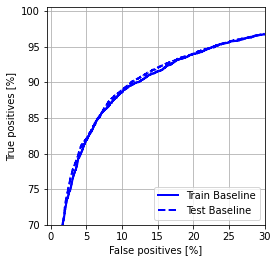

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,30])
  plt.ylim([70,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

train_prediction = new_model.predict(X_to_train[indices], batch_size=BATCH_SIZE, verbose=0)
plot_roc("Train Baseline", Y_train[indices], train_prediction, color='b')
plot_roc("Test Baseline", Y_test, predictions, color='b', linestyle='--')
plt.legend(loc='lower right')

Percentage of Fraud: 3.08% 3.32%


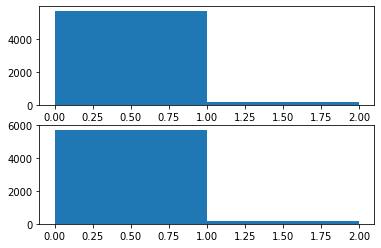

In [ ]:
prediction = np.squeeze(predictions, axis=1)

plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>0.9).astype('int'), bins=[0,1,2])

fraud_predict = np.unique((prediction>0.85).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")



# ***Output the result into a file for a validation with Kaggle***

In [18]:
import os
os.chdir("/content")
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv', names=saved_columns, header=0)
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [19]:
dataset_transaction = None
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  a = test_identity.pop(column)

In [ ]:
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,24.0,match_status:2,T,F,T,T,mobile
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,T,T,F,desktop
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,NaN,F,F,T,F,mobile
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile


In [20]:
merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = merged_data.pop('TransactionID')
test_transaction = None
merged_data.shape

(506691, 428)

In [24]:
cols = ['isFraud']
for i in range(14):
  if np.any(np.isnan(merged_data['C'+str(i+1)])):
    print('C'+str(i+1), np.sum(np.isnan(merged_data['C'+str(i+1)])), np.sum(np.isnan(merged_data['C'+str(i+1)]))/len(merged_data)*100)
  else:
    cols.append('C'+str(i+1))
print(cols)

C1 3 0.000592076827889187
C2 3 0.000592076827889187
C3 3 0.000592076827889187
C4 3 0.000592076827889187
C5 3 0.000592076827889187
C6 3 0.000592076827889187
C7 3 0.000592076827889187
C8 3 0.000592076827889187
C9 3 0.000592076827889187
C10 3 0.000592076827889187
C11 3 0.000592076827889187
C12 3 0.000592076827889187
C13 4748 0.9370602596059532
C14 3 0.000592076827889187
['isFraud']


In [ ]:
test_transaction = copy.copy(merged_data)
merged_data = None
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = []
for column in skip_int_columns:
  int_columns_test.remove(column)

skip_obj_colums = ['']
print(len(float_columns_test), len(int_columns_test), len(obj_columns_test))

399 2 27


In [ ]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean):
  X_out = copy.copy(X)
  X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = 0
  return X_out.astype('float16')  


In [ ]:
for column in float_columns_test:
  # Set to float 16
  test_transaction[column].astype('float16')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [ ]:
for column in int_columns_test:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [ ]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

for column in to_remove:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass



Encoded columns: 207


In [ ]:
# Check if we have the same shape with the X_train
#print(test_transaction.shape, X_train.shape)
print(test_transaction.shape)

(506691, 891)


In [ ]:
# Make the prediction and submit the output
result = (new_model.predict(test_transaction)>0.9).astype('int8')
result_pd = pd.DataFrame(result, columns=['isFraud'])
data_to_file = pd.concat([TransactionID, result_pd], axis=1)
data_to_file.head(5)
data_to_file.to_csv("./submission.csv", index=False)
data_to_file.to_csv('/content/gdrive/My Drive/Kaggle/submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "New submission with model_20200804 using Keras METRICS and Relu and with threshold 0.9"

100% 4.83M/4.83M [00:02<00:00, 1.70MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

# ***Debug zone***

In [ ]:
indices = np.where(np.isnan(a) == False)[0]
min_value, max_value, mean_value, normalized_data = normalization_data(a, indices)
print(min_value, max_value, mean_value, np.mean(normalized_data), np.min(normalized_data), np.max(normalized_data))
dataset_transaction['V331'] = normalized_data

0.0 160000.0 721.7418829164045 -2.2733716828843707e-16 -0.004510886768227528 0.9954891132317726


In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
a = {'a': ['Null', 'A', 'B', 'C', 'D']}
df = pd.DataFrame(a)
df
encoded = ohc.fit_transform(df['a'].values.reshape(-1,1)).toarray()    
pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded


,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In [ ]:
b = {'a': ['Null', 'A', 'B', 'C', 'E']}
df_b = pd.DataFrame(b)
ohc_b = OneHotEncoder(handle_unknown='ignore')
ohc_b.fit(df['a'].values.reshape(-1,1))
encoded_b = ohc_b.transform(df_b['a'].values.reshape(-1,1)).toarray()    
pd_encoded_b = pd.DataFrame(encoded_b.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded_b

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [ ]:
for column in obj_columns:
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(dataset_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 5
P_emaildomain 60
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [ ]:
for column in obj_columns_test:
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(test_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 4
P_emaildomain 61
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


**Train val dataset**